# Model Optimization

In [17]:
# Imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

In [3]:
# Load the data
dbpath = "postgresql://postgres@localhost:5432/asoup"
engine = create_engine(dbpath)
encoded_df = pd.read_sql("SELECT * FROM clean_data", engine).set_index("index")
encoded_df.head()

,STATUS,ASK_AMT,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
index,,,,,,,,,,,,,,,,,,,,,
0,1,5000,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1,108590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1,5000,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1,6692,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,142590,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## Data Processing
We want to get rid of outliers, make sure data is good

count    3.429900e+04
mean     2.769199e+06
std      8.713045e+07
min      5.000000e+03
25%      5.000000e+03
50%      5.000000e+03
75%      7.742000e+03
max      8.597806e+09
Name: ASK_AMT, dtype: float64

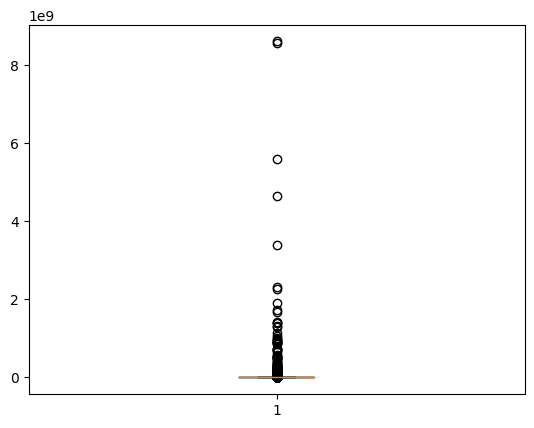

In [21]:
ask_amount = encoded_df["ASK_AMT"]
plt.boxplot(ask_amount)
ask_amount.describe()

In [119]:
# Helper function for organizing outliers data
def get_outliers_data(data: pd.Series, lower: float, upper: float) -> dict:
    """Returns a dictionary with the upper, lower limits, number and percentage of outliers."""
    outliers = data[(data < lower) | (data >= upper)]
    n_outliers = outliers.count()
    return {
        "upper_limit": upper,
        "lower_limit": lower,
        "n_outliers": n_outliers, 
        "percentage": f"{100* n_outliers / ask_amount.count():.2f}%"
    }

In [83]:
# Using IQR
q1 = ask_amount.quantile(0.25)
q3 = ask_amount.quantile(0.75)
iqr = q3 - q1
outliers_iqr = get_outliers_data(ask_amount, q1 - 1.5*iqr, q3 + 1.5*iqr)
outliers_iqr

{'upper_limit': 11855.0,
 'lower_limit': 887.0,
 'n_outliers': 8206,
 'percentage': '23.92%'}

In [84]:
# Using STD
std = ask_amount.std()
mean = ask_amount.mean()
outliers_std = get_outliers_data(ask_amount, mean - std*2, mean + std*2)
outliers_std

{'upper_limit': 177030103.5539489,
 'lower_limit': -171491706.18982753,
 'n_outliers': 80,
 'percentage': '0.23%'}

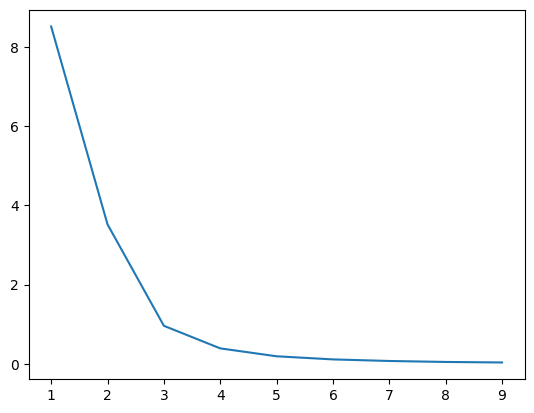

In [116]:
# Clustering with 2 dimensions of data
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

X = encoded_df[["ASK_AMT", "STATUS"]]
X_scaled = MinMaxScaler().fit_transform(X.values)
sse = pd.Series({k: KMeans(n_clusters=k).fit(X_scaled).inertia_ for k in range(1, 10)})
plt.plot(sse.index, sse.values)

In [134]:
# Cluster data
model = KMeans(n_clusters=4, random_state=1).fit(X_scaled)
combined = encoded_df.copy(deep=True)
combined["Cluster"] = model.predict(X_scaled)
print(combined["Cluster"].value_counts())
outliers_kmeans = get_outliers_data(combined["Cluster"], 0, 1) # excluding lower and including upper
outliers_kmeans

0    34261
3       29
1        5
2        4
Name: Cluster, dtype: int64


{'upper_limit': 1, 'lower_limit': 0, 'n_outliers': 38, 'percentage': '0.11%'}

In [130]:
pd.DataFrame({"IQR": outliers_iqr, "STD": outliers_std, "KMeans": outliers_kmeans})

,IQR,STD,KMeans
upper_limit,11855.0,177030103.553949,1
lower_limit,887.0,-171491706.189828,0
n_outliers,8206,80,38
percentage,23.92%,0.23%,0.11%


In [12]:
# Split the Data
y = encoded_df["IS_SUCCESSFUL"].values
X = encoded_df.drop(["IS_SUCCESSFUL"], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
# Scale the data
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((25724, 43), (8575, 43))

In [11]:
# Load the model
nn = tf.keras.models.load_model('trained_successful.h5')
model_loss, model_accuracy = nn.evaluate(X_test_scaled, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 1s - loss: 1.8766 - accuracy: 0.6925 - 619ms/epoch - 2ms/step
Loss: 1.8765658140182495, Accuracy: 0.6924781203269958
